In [1]:
import numpy as np
import pickle
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torchvision import transforms, models
from bs4 import BeautifulSoup
from glob import glob

%matplotlib inline

In [18]:
annotations = glob('./data/annotations/*.xml')

labels = []
bounding_boxes = []
img_paths = []
n_masks = []

for a in annotations:
    with open(a, 'rb') as f:
        content = f.read()

    soup = BeautifulSoup(content, 'xml')

    filename = soup.find('filename').text
    objects = soup.find_all('object')
    n = 0
    for o in objects:
        name = o.find('name').text
        xmin = int(o.find('xmin').text)
        xmax = int(o.find('xmax').text)
        ymin = int(o.find('ymin').text)
        ymax = int(o.find('ymax').text)

        labels.append(name)
        bounding_boxes.append([xmin, ymin, xmax, ymax])

        n = n + 1

    img_paths.append(filename)
    n_masks.append(n)

In [19]:
bounding_boxes[1]

[185, 100, 226, 144]

In [21]:
BASE = './data/images/'
faces = []
j = 0

for i in range(len(img_paths)):
    full_path = BASE + img_paths[i]
    img = cv2.imread(full_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    while(j < len(bounding_boxes)):
        for k in range(n_masks[i]):
            face = img[bounding_boxes[j][1]:bounding_boxes[j][3], bounding_boxes[j][0]:bounding_boxes[j][2]]
            faces.append(face)
        
            j += 1
            
        break

In [23]:
IMG_SIZE = 64
encoded_labels = []

for i in range(len(faces)):
    faces[i] = cv2.resize(faces[i], (IMG_SIZE, IMG_SIZE))
    
for l in labels:
    if l == 'without_mask':
        encoded_labels.append(0)
    elif l == 'with_mask':
        encoded_labels.append(1)
    else:
        encoded_labels.append(2)

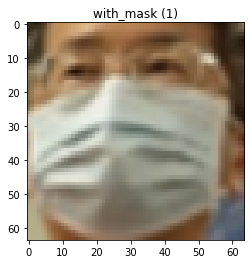

In [26]:
idx = 20

plt.imshow(faces[idx])
plt.title(labels[idx] + ' (' + str(encoded_labels[idx]) + ')')
plt.show()

In [41]:
features = np.asarray(faces)
labels = np.asarray(encoded_labels)

split_val = 0.8
n_train = int(split_val * len(features))

train_features = features[:n_train]
train_labels = labels[:n_train]
test_features = features[n_train:]
test_labels = labels[n_train:]

train_data = torch.utils.data.TensorDataset(torch.from_numpy(train_features), torch.from_numpy(train_labels))
test_data = torch.utils.data.TensorDataset(torch.from_numpy(test_features), torch.from_numpy(test_labels))

BATCH_SIZE = 32
NUM_WORKERS = 0
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)

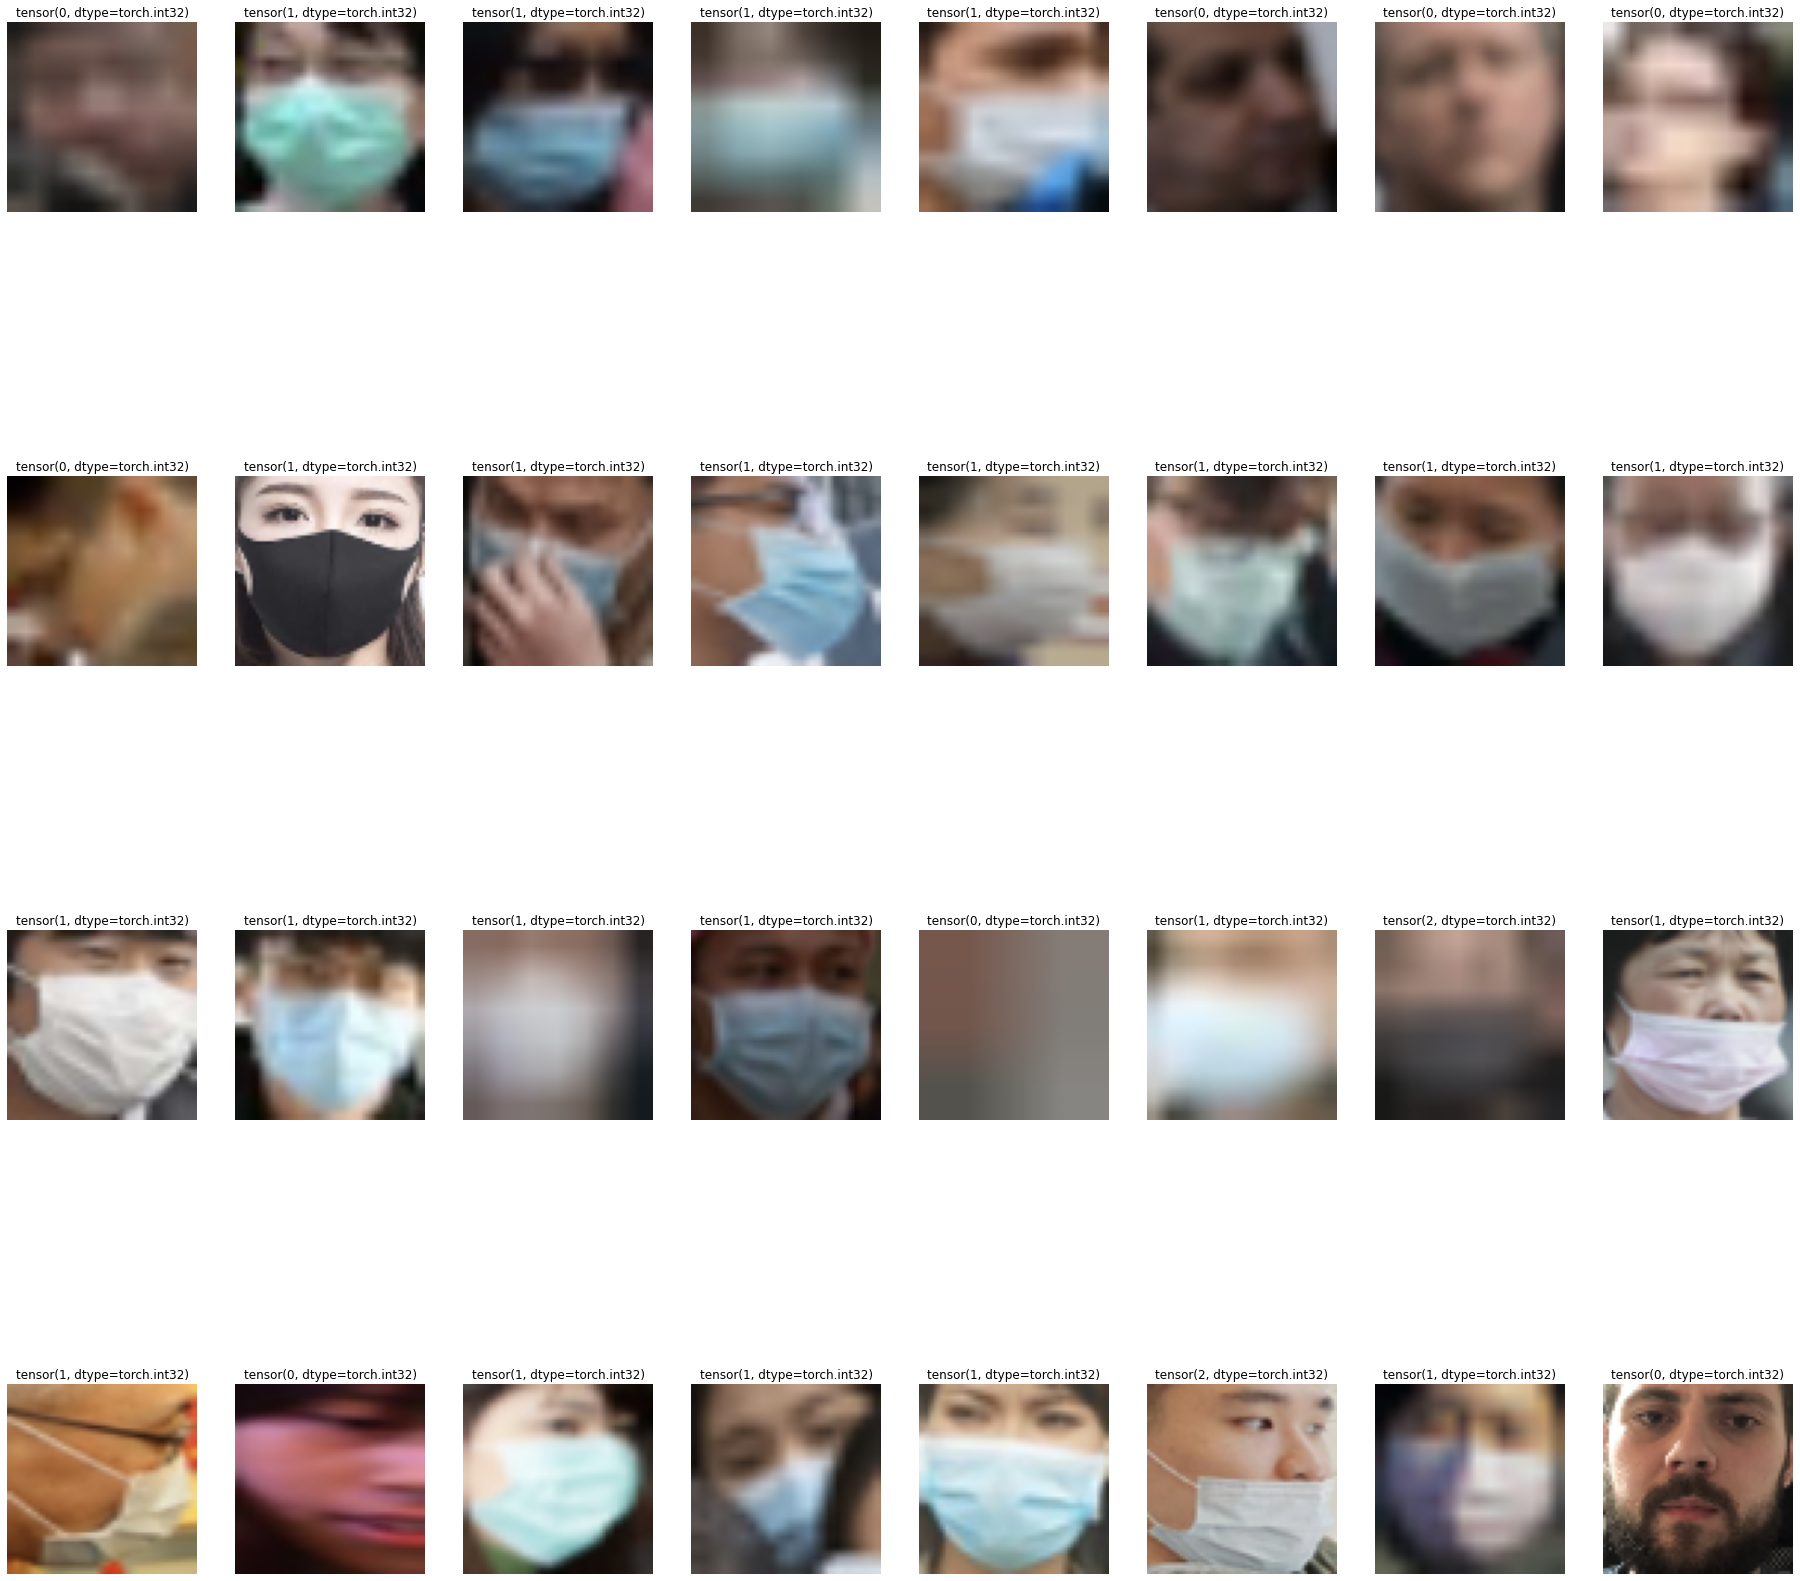

In [49]:
train_batch_x, train_batch_y = iter(train_loader).next()
fig, ax = plt.subplots(4, 8, figsize=(32,32))

for (x, y, axi) in zip(train_batch_x, train_batch_y, ax.flatten()):
    axi.imshow(x)
    axi.set_title(y)
    axi.axis('off')